In [11]:
from utils import show_task_activation, plot_fmap
from utils import process_gray_matter_mask, create_4d_volume, create_events_df, compute_task_fmap, compute_bins_threshold
from utils import subject_gm_mask_path, paradigm_dir, subject_task_active_mask_path, subject_task_regressor_path
from utils import mkdir_no_exist
from viz import plot_voxel_timecourse

import os
from os.path import join as pjoin
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

import nibabel as nib
from nilearn import image
from nilearn.glm import threshold_stats_img
from nilearn.glm.first_level import FirstLevelModel, run_glm
from nilearn.plotting import (
    plot_design_matrix,
    plot_stat_map,
    plot_img,
    plot_glass_brain,
)

In [2]:
HCP_dir = '/media/miplab-nas2/HCP-Data'
paradigm_dir = pjoin(HCP_dir,'HCP_100unrelated_TaskParadigms')
fMRI_dir = pjoin(HCP_dir,'HCP_100unrelated_preprocessed_ERG/data')

project_dir = '/media/RCPNAS/Data2/CS-433-ML4S/'
project_data_dir = pjoin(project_dir, 'data')
derivatives_dir = pjoin(project_data_dir, 'derivatives')

anat_dir = pjoin(derivatives_dir, 'anat')
func_dir = pjoin(derivatives_dir, 'func')
events_dir = pjoin(project_data_dir, 'events')

mkdir_no_exist(anat_dir)
mkdir_no_exist(func_dir)
mkdir_no_exist(events_dir)

In [3]:
subject = "127630"
task = "MOTOR"
acq = "RL"
smoothing = 10
TR = 0.72 

In [4]:
def subject_run(sid, acquisition):
    return {"id": sid, "acquisition": acquisition}

In [5]:
def voxel_activation_glm(mask_img, TR, fmri_vols, events):
    fmri_glm = FirstLevelModel(
        mask_img=mask_img,
        t_r=TR,
        noise_model='ar1', # or ols 
        standardize=False,
        hrf_model='spm',
        drift_model=None, # not necessary, nuisance covariates have already been removed
    )

    print(f"fitting GLM for task {task}")
    fitted_glm = fmri_glm.fit(fmri_vols, events)
    return fitted_glm

In [6]:
def raw_voxel_activity_glm(mask_img, TR, fmri_vols, events):
    fmri_glm = FirstLevelModel(
        mask_img=mask_img,
        t_r=TR,
        noise_model='ar1', # or ols 
        standardize=False,
        hrf_model=None,
        drift_model=None, # not necessary, nuisance covariates have already been removed
        minimize_memory=False,
    )

    print(f"fitting GLM for task {task}")
    fitted_glm = fmri_glm.fit(fmri_vols, events)
    return fitted_glm

In [7]:
def create_active_voxel_mask(subject, task, acquisition, smoothing, voxel_quantile, base_gm_mask_img, fmap_img, threshold):
    task_active_thr_map = subject_task_active_mask_path(subject, task, acquisition, smoothing, voxel_quantile)
    if os.path.isfile(task_active_thr_map):
        return nib.load(task_active_thr_map)

    gm_mask_data = base_gm_mask_img.get_fdata()
    fmap_data = fmap_img.get_fdata()

    threshold_mask = (fmap_data > threshold)

    active_data = fmap_data
    active_data[~threshold_mask] = 0
    active_data[threshold_mask] = 1

    active_img = nib.Nifti1Image(active_data, affine=base_gm_mask_img.affine, header=base_gm_mask_img.header)
    active_img.to_filename(task_active_thr_map)

    return active_img

In [8]:
def prepare_subject_sample(subject, task, acquisition, smoothing, voxel_quantile=98):
    gm_mask = subject_gm_mask_path(subject)
    print("processing subject gray matter mask", gm_mask)
    process_gray_matter_mask(anat_dir, subject, border_size=2, save=True, plot=False)

    print(f"concatenating volumes for task {task}")
    fmri_vols = create_4d_volume(subject, task, acquisition, smoothing, save=True)

    print("processing event conditions")
    independent_events = create_events_df(subject, task, acquisition)
    regressors = scipy.io.loadmat(subject_task_regressor_path(subject, task, acquisition))
    flat_regressors = regressors['Regressor'].flatten()

    print("first GLM to select active voxel")
    activity_glm = voxel_activation_glm(gm_mask, TR, fmri_vols, independent_events)

    print(f"computing f-map and selecting {voxel_quantile}th voxel")
    n_regressors = activity_glm.design_matrices_[0].shape[1]
    contrast_matrix = np.zeros((n_regressors-1, n_regressors))
    np.fill_diagonal(contrast_matrix, 1)
    
    fmap = compute_task_fmap(subject, task, acquisition, smoothing, activity_glm, contrast_matrix)
    threshold = compute_bins_threshold(fmap, n_perc=voxel_quantile)

    gm_mask = nib.load(gm_mask)
    active_mask = create_active_voxel_mask(subject, task, acquisition, smoothing, voxel_activation_glm, gm_mask, fmap, threshold)
    active_mask_data = active_mask.get_fdata()
    
    #plot_img(gm_mask)
    #plot_img(active_mask)

    print("second GLM to extract raw voxel activity")
    raw_voxel_glm = raw_voxel_activity_glm(active_mask, TR, fmri_vols, independent_events)
    predicted = raw_voxel_glm.predicted[0]
    predicted_data = predicted.get_fdata()

    plot_voxel_timecourse(predicted_data[active_mask_data > 0], flat_regressors)

In [9]:
subjetcs = [subject_run("127630", "RL")]

processing subject gray matter mask /media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/127630_gm_mask.nii.gz
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/127630_gm_mask.nii.gz


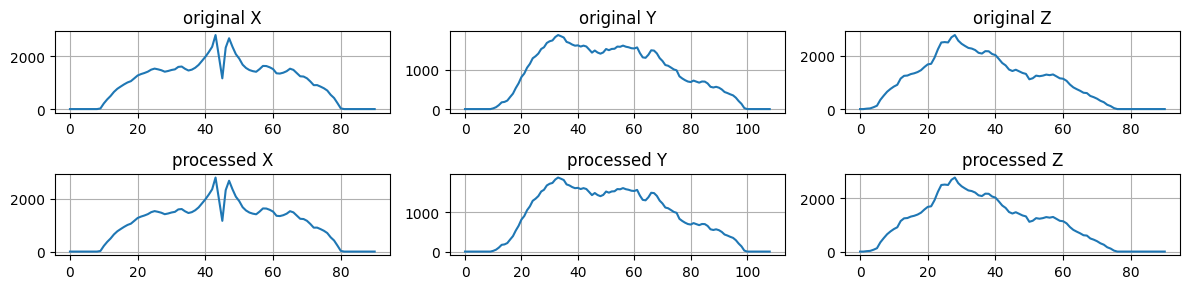

concatenating volumes for task MOTOR
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/127630_MOTOR_RL_smooth-10mm_fMRIvols.nii.gz
files 127630_MOTOR_RL_smooth-10mm_fMRIvols.nii.gz already exists, skipping processing
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/127630_Regressor_tfMRI_MOTOR_RL.mat
/media/RCPNAS/Data2/CS-433-ML4S/data/events/127630_MOTOR_RL_event.csv
first GLM to select active voxel
fitting GLM for task MOTOR
computing f-map and selecting 98th voxel


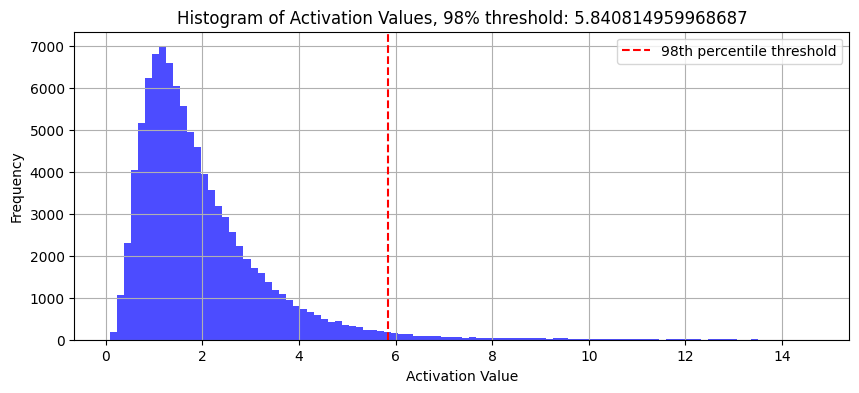

second GLM to extract raw voxel activity
fitting GLM for task MOTOR
discarded 0 / 1937


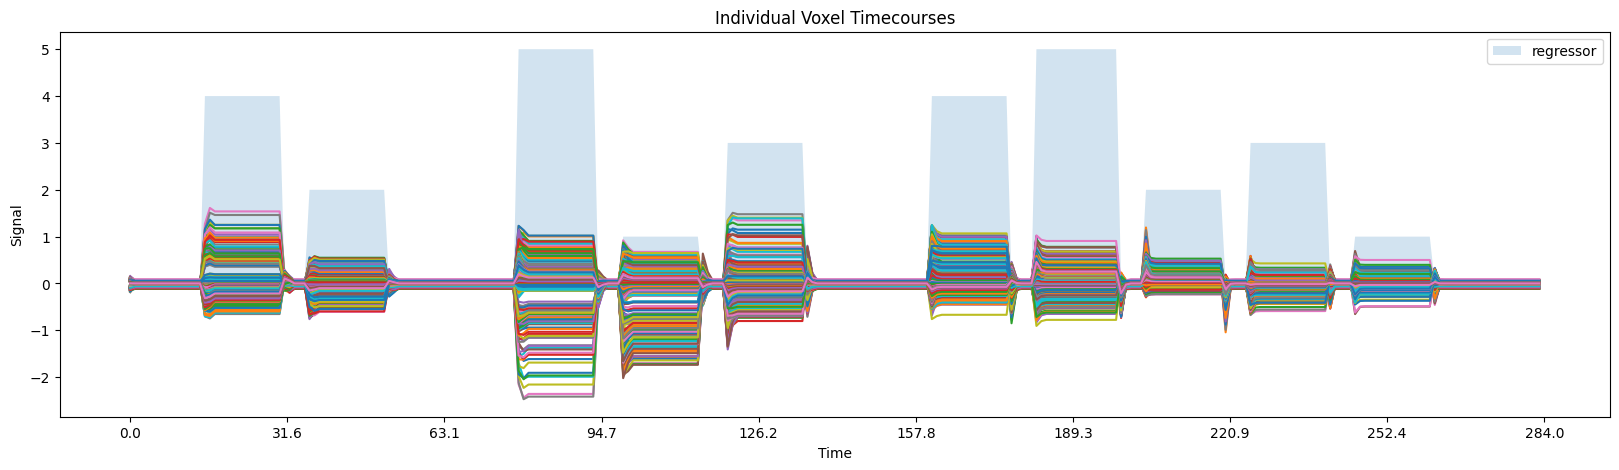

In [12]:
for entry in subjetcs:
    prepare_subject_sample(entry.get("id"), task, entry.get("acquisition"), smoothing=10)

processing subject gray matter mask /media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/113619_gm_mask.nii.gz
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/113619_gm_mask.nii.gz


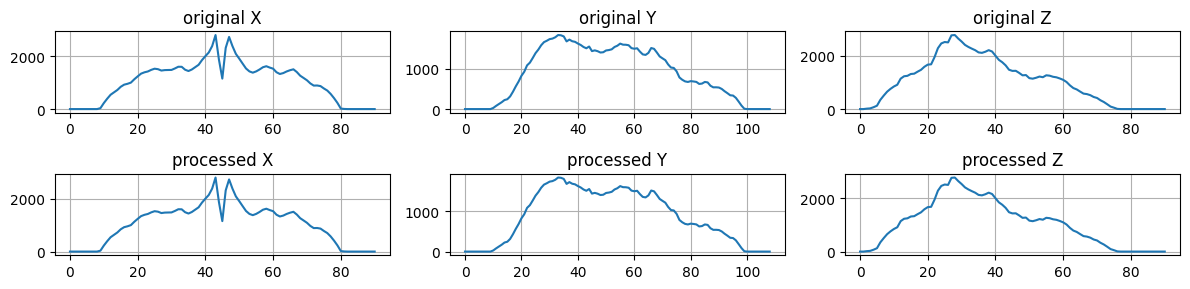

concatenating volumes for task MOTOR
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/113619_MOTOR_LR_smooth-10mm_fMRIvols.nii.gz
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/113619_Regressor_tfMRI_MOTOR_LR.mat
/media/RCPNAS/Data2/CS-433-ML4S/data/events/113619_MOTOR_LR_event.csv
first GLM to select active voxel
fitting GLM for task MOTOR
computing f-map and selecting 98th voxel


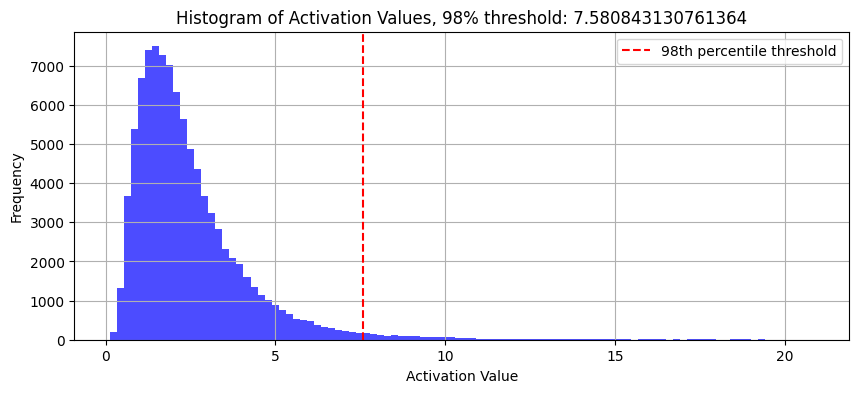

second GLM to extract raw voxel activity
fitting GLM for task MOTOR
discarded 0 / 1930


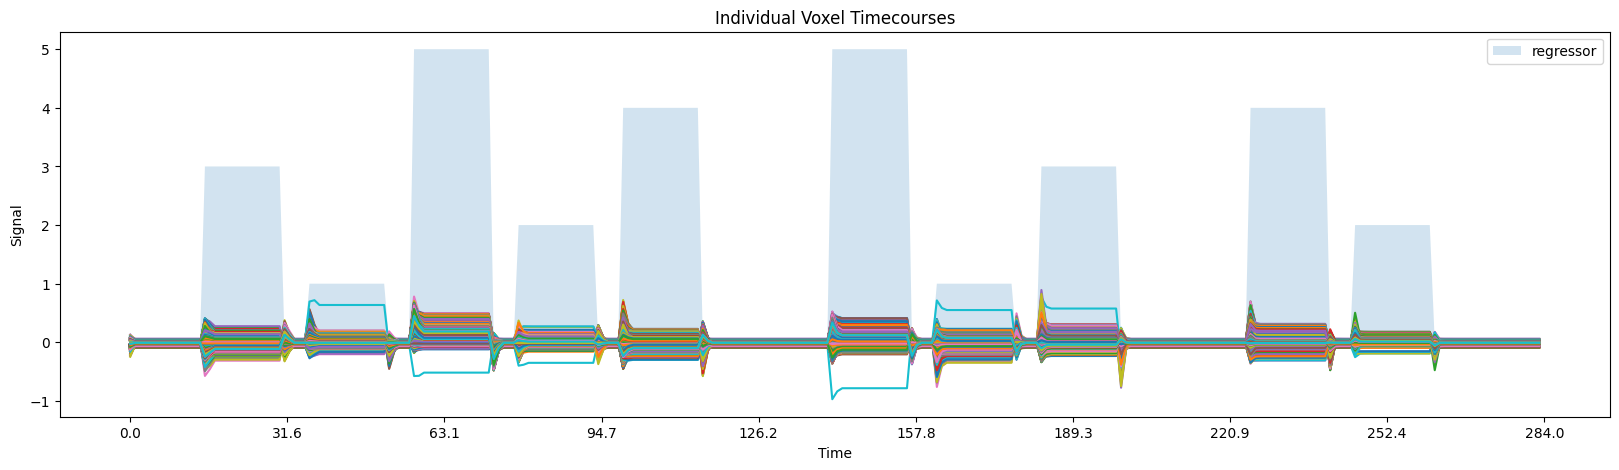

In [14]:
prepare_subject_sample("113619", task, "LR", smoothing=10)